# Histogramming and plotting

### Histograms mean different things in different contexts
- counts, bin edges - useful for a bar plot - `np.histogram` / `plt.bar`
- counts, bin edges, pre computed errors - `TGraphErrors`/`plt.errorbar`
- weighted values, weights squared, bin_edges - proper error calculation `TH1`/`Coffea.hist`/`hist`

## UHI - [Unified Histogram Interface](https://uhi.readthedocs.io/en/latest/plotting.html#using-the-protocol)
- (Plottable) Histogram protocol - designed to make libraries interoperable, easy to navigate
  - Conformed to by `hits`, `mplhep`, `uproot4`, `histoprint`
- Each UHI histogram has the following methods
  - `h.values()`: The value (as given by the kind)
  - `h.variances()`: The variance in the value (None if an unweighed histogram was filled with weights)
  - `h.counts()`: How many fills the bin received or the effective number of fills if the histogram is weighted
  - `h.axes`: A Sequence of axes
  - and a few other properties

## [hist](https://github.com/scikit-hep/hist)
- python go to one-stop for histogramming
- extends [boost-histogram](https://github.com/scikit-hep/boost-histogram.html) (pythonic wrapper for C++ library - *FAST*)
  - makes it user friendly
- shortcuts for convenience - plotting/fitting

## [mplhep](https://github.com/scikit-hep/mplhep)
- build on top of `matplotlib`
- extends functionality to easily plot histograms from various inputs
- holds style sheets for easy experiment specific style application

# Basics

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Numpy histogram
H = np.histogram(np.random.normal(5, 1, 1000), np.linspace(0, 10, 11))
h, bins = H
h

array([  0,   0,  20, 138, 353, 335, 128,  24,   2,   0])

Text(0.5, 1.0, 'Now native histogram `stairs` plot')

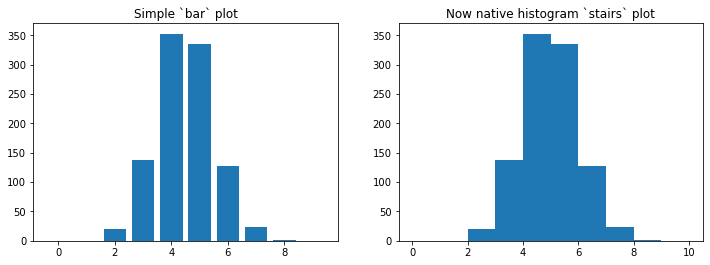

In [3]:
# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].bar(range(len(h)), h)
axs[0].set_title('Simple `bar` plot')
axs[1].stairs(h, bins, fill=True)
axs[1].set_title('Now native histogram `stairs` plot')

# Extending plotting with `mplhep`
- primary goal is to stay unobtrusive, if it works in `matplotlib`, it should work in `mplhep`

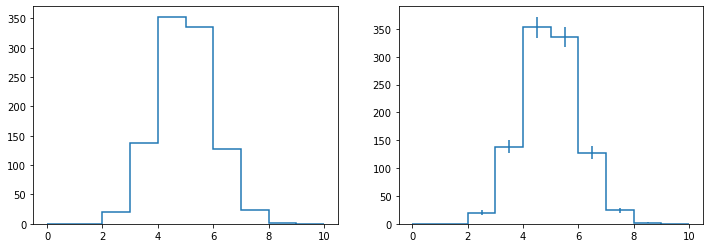

In [4]:
import mplhep as hep
f, axs = plt.subplots(1,2, figsize=(12, 4))

hep.histplot(H, ax=axs[0])
hep.histplot(h, bins, yerr=True, ax=axs[1]);

### kwargs are passed though to `matplotlib`

[ErrorBarArtists(errorbar=<ErrorbarContainer object of 3 artists>)]

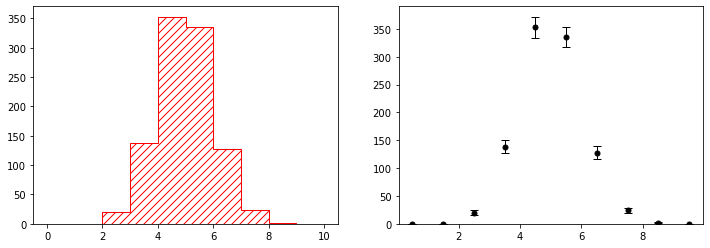

In [5]:
f, axs = plt.subplots(1,2, figsize=(12, 4))

hep.histplot(H, ax=axs[0], histtype='fill', hatch='///', edgecolor='red', facecolor='none')
hep.histplot(H, ax=axs[1], histtype='errorbar', yerr=True, c='black', capsize=4)

### Stacking, norming is available

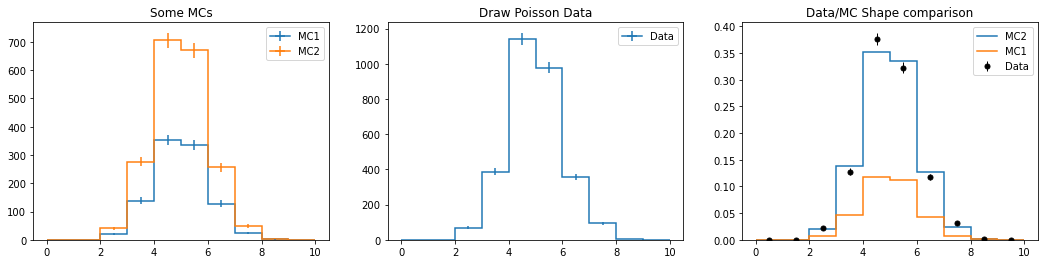

In [6]:
f, axs = plt.subplots(1,3, figsize=(18, 4))

data = np.random.poisson(h*3)
hep.histplot([h, h*2], bins=bins, ax=axs[0], yerr=True, label=["MC1", "MC2"])
hep.histplot(data, bins=bins, ax=axs[1], yerr=True, label="Data")

hep.histplot([h, h*2], bins=bins, ax=axs[2], stack=True, label=["MC1", "MC2"], density=True)
hep.histplot(data, bins=bins, ax=axs[2], yerr=True, histtype='errorbar', label="Data", density=True, color='k')
for ax in axs:
    ax.legend()
axs[0].set_title("Some MCs")
axs[1].set_title("Draw Poisson Data")
axs[2].set_title("Data/MC Shape comparison"); 

### Convenient sorting options

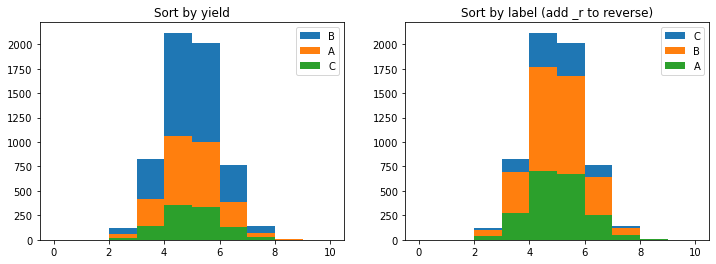

In [7]:
f, axs = plt.subplots(1,2, figsize=(12, 4))
hep.histplot([h*2, h*3, h], bins=bins, ax=axs[0], stack=True, histtype='fill', label=["A", "B", "C"], sort='yield');
hep.histplot([h*2, h*3, h], bins=bins, ax=axs[1], stack=True, histtype='fill', label=["A", "B", "C"], sort='label_r');
for ax in axs:
    ax.legend()
axs[0].set_title("Sort by yield")
axs[1].set_title("Sort by label (add _r to reverse)");

### Can pass either pre-computed error bars or `fcn(weight, weights2)`

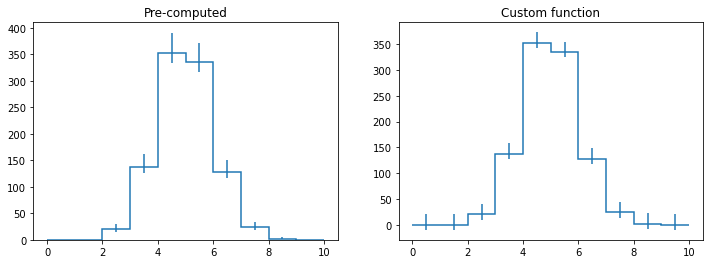

In [8]:
def err(w, w2):
    return w - 10, w2 + 20

f, axs = plt.subplots(1,2, figsize=(12, 4))
hep.histplot(h, bins=bins, yerr=[np.sqrt(h), np.sqrt(h)*2], ax=axs[0]);
hep.histplot(h, bins, w2=h, w2method=err, ax=axs[1]);

axs[0].set_title("Pre-computed")
axs[1].set_title("Custom function");

### Inputs types are flexible
- already shown `np.array`, `List[np.array]`, `np.ndarray`
- will show `hist.Hist` / `List[hist.Hist]`
- but also *anything* that is PlottableProtocol compatible

['hpx;1', 'hpxpy;1', 'hprof;1', 'ntuple;1']
<TH1F (version 1) at 0x7f3321380220>


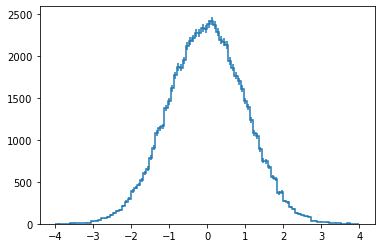

In [9]:
## Uproot TH1 
import uproot
from skhep_testdata import data_path
fname = data_path("uproot-hepdata-example.root")
f = uproot.open(fname)
print(f.keys())
print(f['hpx'])
hep.histplot(f['hpx']);

In [10]:
# PyROOT TH1
import os
if "ROOTSYS" in os.environ:
    import ROOT
    h = ROOT.TH1F("h1", "h1", 50, -2.5, 2.5)
    h.FillRandom("gaus", 10000)

    hep.histplot(h);

# hist - basics
- easy histogram handling - filling, slicing, (merging, serializing)
- Nice repr, interfaces to `mplhep` for plotting

In [11]:
import hist
# from hist import Hist

In [12]:
# Creating a histogram object
h = hist.new.Reg(10, 0, 10).Double()
h

Hist(Regular(10, 0, 10, label='Axis 0'), storage=Double())

In [13]:
# Equivalent to 
h = hist.Hist(
    hist.axis.Regular(
        10, 0, 10, 
        # Optionally include name/label, whether to keep flow bins
        name="x", label="Fancy display name", underflow=False, 
        )
    )   
h

Hist(Regular(10, 0, 10, underflow=False, name='x', label='Fancy display name'), storage=Double())

In [14]:
# Fill it
h.fill(np.random.normal(5, 1, 1000))
h

Hist(Regular(10, 0, 10, underflow=False, name='x', label='Fancy display name'), storage=Double()) # Sum: 1000.0

In [15]:
# Print it (to CLI)
h.show(columns=50)

 0.00e+00 _                             3.59e+02 ╷
 1.00e+00 _
 2.00e+00 _
 3.00e+00 _█
 4.00e+00 _█████████████
 5.00e+00 _███████████████████████████████████
 6.00e+00 _███████████████████████████████████████
 7.00e+00 _███████████████
 8.00e+00 _██
 9.00e+00 _
 1.00e+01 _


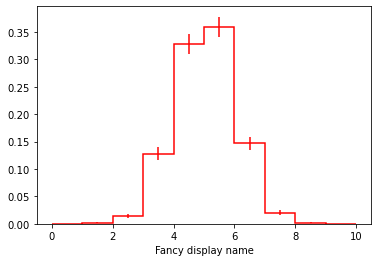

In [16]:
# Plot it
h.plot(color='red', density=True);

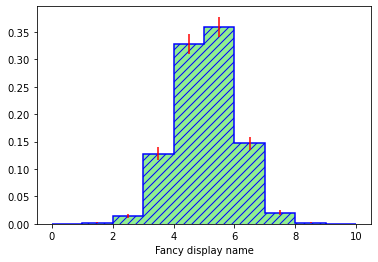

In [17]:
# Access and modify artists
art = h.plot(color='red', density=True);
plt.setp(art[0].stairs, edgecolor='blue', fill=True, facecolor='lightgreen', hatch='///');

### hist - basic operations

In [18]:
# Slicing
h[2:4]

Hist(Regular(2, 2, 4, underflow=False, name='x', label='Fancy display name'), storage=Double()) # Sum: 142.0 (998.0 with flow)

In [19]:
# Slicing in data coordinates
h[1j:6j]

Hist(Regular(5, 1, 6, underflow=False, name='x', label='Fancy display name'), storage=Double()) # Sum: 831.0 (1000.0 with flow)

In [20]:
# Get total
h.sum()

1000.0

### hist - properties (PlottableHistogram)

In [21]:
print(h.values())
print(h.variances())
print(h.axes[0])
print(h.axes[0].centers)

[  0.   2.  14. 128. 328. 359. 147.  20.   2.   0.]
[  0.   2.  14. 128. 328. 359. 147.  20.   2.   0.]
Regular(10, 0, 10, underflow=False, name='x', label='Fancy display name')
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


## hist - multiple dimensions and indexing
- analysis like example

In [22]:
# Create a new hist
h2d = hist.new.Reg(10, 0, 10, name='x').StrCat(["A", "B"], growth=True, name='dataset').Weight()
h2d

Hist(
  Regular(10, 0, 10, name='x', label='x'),
  StrCategory(['A', 'B'], growth=True, name='dataset', label='dataset'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0)

In [23]:
# Fill it
h2d.fill(np.random.normal(3, 1, 1000), "A")
h2d.fill(np.random.normal(5, 1, 3000), "B")
h2d.fill(np.random.normal(7, 1, 2000), "C")
h2d

Hist(
  Regular(10, 0, 10, name='x', label='x'),
  StrCategory(['A', 'B', 'C'], growth=True, name='dataset', label='dataset'),
  storage=Weight()) # Sum: WeightedSum(value=5998, variance=5998) (WeightedSum(value=6000, variance=6000) with flow)

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


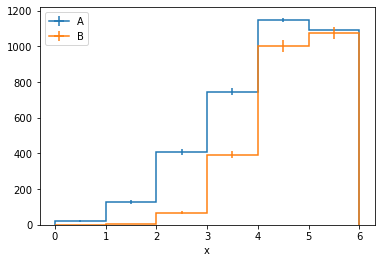

In [24]:
h2d[:6, ["A", "B"]].plot(stack=True, histtype='step', sort='y_r');
plt.legend()

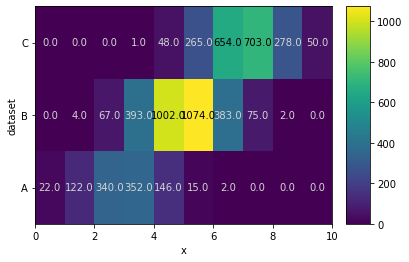

In [25]:
hep.hist2dplot(h2d, labels=True);

### Analysis like example

In [26]:
hn = (hist.new.Reg(100, 0, 100, name='x', label='Observable')
      .Var([0, 0.2, 0.5, 0.9, 1], name="tag", label="Some MVA")
      .StrCat(["A"], growth=True, name='dataset')
      .IntCat([0, 1, 2, 3], name='region')
      .StrCat(["A"], growth=True, name='syst', label='Systematic')
      .Weight()
     )

In [27]:
# Small random letter helper
def rnd_letters(a="A", z="Z", N=10):
    A, Z = np.array([a, z]).view("int32") 
    return list(np.random.randint(low=A,high=Z,size=N,dtype="int32").view(f"U{N}")[0])
rnd_letters("C", "F")

['C', 'E', 'C', 'C', 'C', 'E', 'C', 'E', 'D', 'C']

In [28]:
# And fill it
N = 400000
for sample in set(rnd_letters("A", "G", 500)):
    hn.fill(x = np.random.normal(np.random.randint(20, 80, 1), 10, N),
            tag = np.random.uniform(0, 1, N),
            dataset = sample,
            region=np.random.randint(0, 4, N),
            syst = rnd_letters("P", "Z", N=N)
            )
hn

Hist(
  Regular(100, 0, 100, name='x', label='Observable'),
  Variable([0, 0.2, 0.5, 0.9, 1], name='tag', label='Some MVA'),
  StrCategory(['A', 'F', 'D', 'B', 'E', 'C'], growth=True, name='dataset', label='dataset'),
  IntCategory([0, 1, 2, 3], name='region', label='region'),
  StrCategory(['A', 'W', 'Q', 'T', 'Y', 'S', 'P', 'X', 'V', 'U', 'R'], growth=True, name='syst', label='Systematic'),
  storage=Weight()) # Sum: WeightedSum(value=2.3883e+06, variance=2.3883e+06) (WeightedSum(value=2.4e+06, variance=2.4e+06) with flow)

In [29]:
# Simple slices
hn[:, 0.5j:len:sum, :, 0, "X"]

Hist(
  Regular(100, 0, 100, name='x', label='Observable'),
  StrCategory(['A', 'F', 'D', 'B', 'E', 'C'], growth=True, name='dataset', label='dataset'),
  storage=Weight()) # Sum: WeightedSum(value=29664, variance=29664) (WeightedSum(value=29804, variance=29804) with flow)

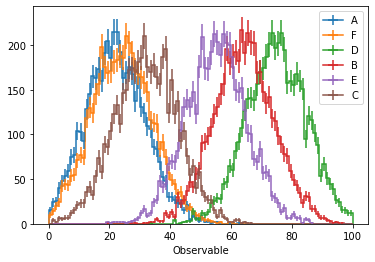

In [30]:
# Slice by name
s = hist.tag.Slicer()
hn[{'tag': s[0.5j:len:sum], 'region': 0, 'syst': "X"}].plot();
plt.legend();

### Scale "sample" by "cross-section"

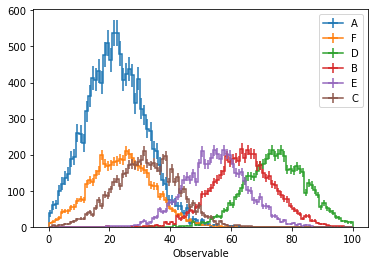

In [31]:
hn[{'dataset': "A"}] = hn[{'dataset': "A"}].view() * 2.5

hn[{'tag': s[0.5j:len:sum], 'region': 0, 'syst': "X"}].plot();
plt.legend();

### Group datasets (to be replaced by native hist function)

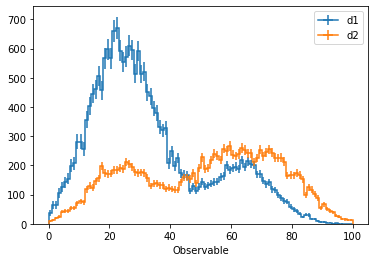

In [32]:
def groupby(h, groupmap, axis='dataset'):
    new = hist.Hist(*[ax for ax in h.axes if ax.name != axis], 
                hist.axis.StrCategory(groupmap.keys(), name=axis, growth=True), 
                hist.storage.Weight()
          )

    for name, cats in groupmap.items():
        grouped = sum([h[{axis: name}] for name in cats])
        new[{axis: name}] = grouped.view(flow=True)
    return new

groupby(hn, {"d1": ["A", "B", "C"], 'd2': ["D", "E", 'F']})[{'tag': s[0.5j:len:sum], 'region': 0, 'syst': "X"}].plot();
plt.legend();

### Desired end goal - 1D templates of each sample, passing a cut, per region per systematic

In [33]:
cut = {'tag': s[0.5j:len:sum]} # Events passing 0.5 threshold

templates = {}
for sample in hn.axes['dataset']:
    for region in hn.axes['region']:
        for syst in hn.axes['syst']:
            template_name = f"region{region}_{sample}_sys{syst}"
            templates[template_name] = hn[{**cut, 'dataset': sample, 'region': region, 'syst': syst}]

In [34]:
templates['region0_B_sysX']

# and write these via uproot

Hist(Regular(100, 0, 100, name='x', label='Observable'), storage=Weight()) # Sum: WeightedSum(value=4967, variance=4967)

# Styling with mplhep
- Primary purpose of `mplhep` is to serve and distribute styles 
    - **ALICE**
    - **ATLAS**
    - **CMS**
    - **LHCb**
- To ensure plots looks the same on any framework fonts need to be included
 - I am liable to go on a rant, so suffice to say:
 - We package an open look-alike of Helvetica called Tex Gyre Heros

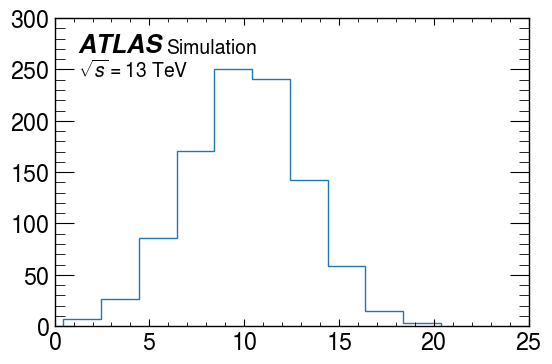

In [35]:
hep.style.use([hep.style.ATLAS, {'figure.figsize': (6, 4)}])
hep.histplot(np.histogram(np.random.normal(10, 3, 1000)));
hep.atlas.label();

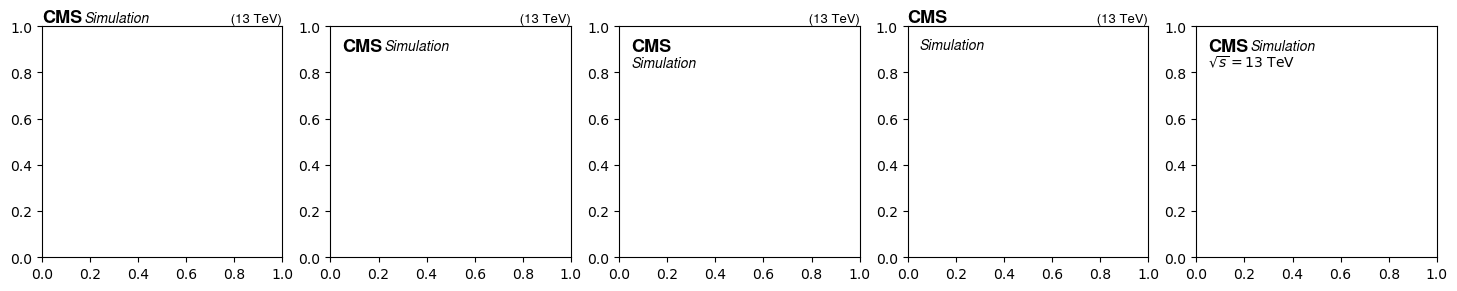

In [36]:
hep.style.use()
fig, axs = plt.subplots(1, 5, figsize=(18, 3))
for i, ax in enumerate(axs):
    hep.cms.label(ax=ax, loc=i)